<a href="https://colab.research.google.com/github/z1qsx/NLP-Methods_for_sentence_completion/blob/master/Methods_for_sentence_completion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced natural language processing 

In [0]:
# import module
import os,random,math
from nltk import word_tokenize as tokenize
import operator
import nltk
import gensim
# nltk.download('punkt')
from nltk.util import ngrams
from nltk import ngrams 
import tensorflow as tf
import numpy as np
from scipy import spatial
import pickle
import numpy as np
import time
import csv
import random
import glob
import re
import argparse
import os
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

In [0]:
#loading the Google news vector
Go_model=gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary=True)

In [0]:
# import pickle
# with open("t400.txt", "rb") as fp:   # Unpickling
#       t400 = pickle.load(fp)

## Data pre-processing for Similarity computing

In [0]:
#cleaning string
# Cleaning code reference to github

def data_cleaning(string):
    
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\?", " ? ", string)
    string = re.sub(r";", " ; ", string)
    string = re.sub(r"\[([^\]]+)\]", " ", string)
    string = re.sub(r"\(([^\)]+)\)", " ", string)
    string = re.sub(r"[^A-Za-z,!?.;]", " ", string)  
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

def pre_data(input_files, data_path):
    collect_corpus = []
    for input_file in input_files:
        with open(input_file, "r", encoding='utf-8', errors='ignore') as f:
            print("loading data {}".format(input_file))
            corpus = data_cleaning(f.read())
            sentences = re.split(r"(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=[.?;!])\s",corpus)
            clean_sent = []
            for sent in sentences:
                s = sent.translate(str.maketrans('','',string.punctuation))
                tokens = s.strip().split()
                important_words = []
                for word in tokens:
                    #cleaning the stopwords
                    if word  not in stopwords.words('english'):
                        important_words.append(word)
                        
                if len(important_words) > 5:
                    clean_sent.append(" ".join(important_words)) 
        collect_corpus += clean_sent
        
    #saving the data
    with open(data_path, 'wb') as f:
        pickle.dump(all_corpus, f)

    return collect_corpus 

In [0]:
#computing the similarity distance
def total_sim(vec, ques_vec):
    score = 0
    for v in ques_vec:
        score += (1 - spatial.distance.cosine(vec, v))
    return score

#collecting the word embedding 
def word2vec(tokens, embeddings):
    dim = embeddings['word'].size
    word_vec = []
    for word in tokens:
        if word in embeddings:
            word_vec.append(embeddings[word])
        else:
            word_vec.append(np.random.uniform(-0.25,0.25,dim))
    return word_vec


In [0]:
def load_train(data_dir,save_dir):
    input_data = glob.glob(os.path.join(data_dir, "*.TXT"))
   
    source_data = os.path.join(save_dir, 'clean_data.pkl')
    
    #Loading preprocessed training data
    if os.path.exists(source_data): 
        with open(source_data, 'rb') as f:
            clean_corpus = pickle.load(f)
    else: 
        #Processing training data
        clean_corpus = pre_data(input_data, source_data)

    return clean_corpus

In [0]:
corpus = load_train('lab3resources/sentence-completion/Holmes_Training_Data','lab3resources/')

print("Total training sentences: {}".format(len(corpus)))

Total training sentences: 1377217


In [0]:
#loang the cleaned data
def load_cleaned_data(path)    
    clean_corpus =load_train(path,save_dir)
    
    all_doc=[]
    for words in clean_corpus:
        all_doc.append(tokenize(words))
    return corpus_all

In [0]:
all_doc=load_cleaned_data('lab3resources/')

In [0]:
with open("all_doc_clean.txt", "wb") as fp:   #Pickling
    pickle.dump(all_doc, fp)

In [0]:
#Employing the cleaned data to obtain the word embedding
from gensim.models import Word2Vec
model = Word2Vec(all_doc, sg=1, size=100,  window=5,  min_count=5,  negative=3, sample=0.001, hs=1, workers=4)

## language model

### N-gram model

In [0]:
from k_language_model import *  

In [0]:
import os
training,testing=get_training_testing(TRAINING_DIR,1)

There are 1044 files in the training directory: lab3resources/sentence-completion/Holmes_Training_Data


In [0]:
# my_lag_800=language_model(files=training[:1000])

In [0]:
#training 100 to 1000 documents N-gram model
my_lag_100=language_model(files=training[:100])
my_lag_200=language_model(files=training[:200])
my_lag_400=language_model(files=training[:400])
my_lag_600=language_model(files=training[:600])
my_lag_800=language_model(files=training[:800])
my_lag_1000=language_model(files=training[:1000])

In [0]:
with open("tridata_1000.txt", "wb") as fp:   #Pickling
    pickle.dump(tr_tri, fp)

In [0]:
# model_word = gensim.models.Word2Vec(t400)

### LSA

In [0]:
def build_lsa_feature(corpus, save_dir):
    dict_file = os.path.join(save_dir, 'lsa_word_dict3.pkl')
    if os.path.exists(dict_file):
        print("Loading LSA word dictionary")
        with open(dict_file,'rb') as f:
            word_dict = pickle.load(f)
    else:
        print("Building word features with LSA")
        
        vectorizer = CountVectorizer(analyzer = 'word', tokenizer = None, preprocessor= None, stop_words = None, max_features = 14000)
        bow_features = vectorizer.fit_transform(corpus)
        bow_features.asfptype()
    
        
        lsa = TruncatedSVD(200)
        
        word_features = lsa.fit_transform(bow_features)
#         word_features = lsa.fit_transform(bow_features.T)
        word_features = Normalizer(copy=False).fit_transform(word_features)
        
        vocabulary = vectorizer.get_feature_names()
        word_dict = {}
        for i, word in enumerate(vocabulary):
            word_dict[word] = word_features[i]

        with open(dict_file, 'wb') as f:
            pickle.dump(word_dict, f)

    return word_dict
#         return bow_features

In [0]:
word_dict = build_lsa_feature(corpus,'lab3resources/')

Building word features with LSA


## Sentence Completion Challenge

In [0]:
import csv
import pandas as pd
import sys

#reading question

questions=os.path.join('testing_data.csv')
answers=os.path.join('test_answer.csv')

with open(questions) as instream:
    csvreader=csv.reader(instream)
    lines=list(csvreader)
qs_df=pd.DataFrame(lines[1:],columns=lines[0])
qs_df.head()

,id,question,a),b),c),d),e)
0,1,I have it from the same source that you are bo...,crying,instantaneously,residing,matched,walking
1,2,It was furnished partly as a sitting and partl...,daintily,privately,inadvertently,miserably,comfortably
2,3,"As I descended , my old ally , the _____ , cam...",gods,moon,panther,guard,country-dance
3,4,"We got off , _____ our fare , and the trap rat...",rubbing,doubling,paid,naming,carrying
4,5,"He held in his hand a _____ of blue paper , sc...",supply,parcel,sign,sheet,chorus


In [0]:
# qs_df['cleaned'] = qs_df['question'].apply(lambda x:''.join([i for i in x if i not in string.punctuation]))

In [0]:
# qs_df['tokens']=qs_df['cleaned'].map(tokenize)
# qs_df['context']=qs_df['tokens'].map(lambda x:get_left_context(x,1))

In [0]:
#removing punctuation
import string
def remove_pun(question):
    translator = str.maketrans('','',string.punctuation)
    question = question.translate(translator)
    tokens = question.split()
    return tokens

In [0]:
#geting left and right words
def get_left_contextg(sent_tokens,window,windows=0,target="_____",flag='left'):
    found=-1
    for i,token in enumerate(sent_tokens):
        if token==target:
            found=i 
            break
    if found>-1:
        if flag=='left':
            str1 = " ".join(sent_tokens[:i])
            left_data=remove_pun(str1)
            return left_data
        elif flag=='right':
            str2 = " ".join(sent_tokens[i+1:])
            right_data=remove_pun(str2)
            return right_data
    else:
        return []

In [0]:
qs_df['tokens']=qs_df['question'].map(tokenize)
qs_df['all_left']=qs_df['tokens'].map(lambda x:get_left_contextg(x,1))
qs_df['all_right']=qs_df['tokens'].map(lambda x:get_left_contextg(x,1,flag='right'))

In [0]:
qs_df.iloc[1][8][-2]+' '+qs_df.iloc[1][8][-1]

'flowers arranged'

In [0]:
def get_left_context(sent_tokens,window,windows=0,target="_____"):
    found=-1
    for i,token in enumerate(sent_tokens):
        if token==target:
            found=i
            break
    if found>-1:
        return sent_tokens[i-window:i+windows]
    else:
        return []

In [0]:
qs_df['tokens']=qs_df['question'].map(tokenize)
qs_df['context']=qs_df['tokens'].map(lambda x:get_left_context(x,1))
qs_df['context_later']=qs_df['tokens'].map(lambda x:get_left_context(x,-1,2))

qs_df['context_laterx']=qs_df['tokens'].map(lambda x:get_left_context(x,-2,3))
qs_df['contextx']=qs_df['tokens'].map(lambda x:get_left_context(x,2,-1))

In [0]:
qs_df['tokens']=qs_df['question'].map(tokenize)
qs_df['context']=qs_df['tokens'].map(lambda x:get_left_context(x,3)).apply(lambda x:' '.join([i for i in x if i not in string.punctuation]))
qs_df['context_later']=qs_df['tokens'].map(lambda x:get_left_context(x,-1,4)).apply(lambda x:' '.join([i for i in x if i not in string.punctuation]))
qs_df.head()

,id,question,a),b),c),d),e),tokens,context,context_later
0,1,I have it from the same source that you are bo...,crying,instantaneously,residing,matched,walking,"[I, have, it, from, the, same, source, that, y...",bachelor and are,alone in London
1,2,It was furnished partly as a sitting and partl...,daintily,privately,inadvertently,miserably,comfortably,"[It, was, furnished, partly, as, a, sitting, a...",with flowers arranged,in every nook
2,3,"As I descended , my old ally , the _____ , cam...",gods,moon,panther,guard,country-dance,"[As, I, descended, ,, my, old, ally, ,, the, _...",ally the,came out
3,4,"We got off , _____ our fare , and the trap rat...",rubbing,doubling,paid,naming,carrying,"[We, got, off, ,, _____, our, fare, ,, and, th...",got off,our fare
4,5,"He held in his hand a _____ of blue paper , sc...",supply,parcel,sign,sheet,chorus,"[He, held, in, his, hand, a, _____, of, blue, ...",his hand a,of blue paper


In [0]:
class scc_reader():
    
    def __init__(self,qs=questions,ans=answers):
        self.qs=qs
        self.ans=ans
        self.read_files()            
    def read_files(self):  
        #read in the question file
        with open(self.qs) as instream:
            csvreader=csv.reader(instream)
            qlines=list(csvreader)
#             print(qlines)
        #store the column names as a reverse index so they can be used to reference parts of the question
        question.colnames={item:i for i,item in enumerate(qlines[0])}   
        #create a question instance for each line of the file (other than heading line)
        self.questions=[question(qline) for qline in qlines[1:]]    
        #read in the answer file
        with open(self.ans) as instream:
            csvreader=csv.reader(instream)
            alines=list(csvreader)
 
        #add answers to questions so predictions can be checked    
        for q,aline in zip(self.questions,alines[1:]):  
            q.add_answer(aline)
            
    def get_field(self,field):     
        return [q.get_field(field) for q in self.questions] 
    
    def predict(self,method="chooseA"):
        return [q.predict(method=method) for q in self.questions]
    
    def predict_and_score(self,dataset,method="chooseA"):
        scores=[q.predict_and_score(dataset,method=method) for q in self.questions]
        return sum(scores)/len(scores)

In [0]:
class question():  
    def __init__(self,aline):
        self.my_lag=0
        self.fields=aline
        self.ansd={0:'a',1:'b',2:'c',3:'d',4:'e'}
        self.choices = ['a', 'b', 'c', 'd', 'e'] 
        
        self.question=remove_pun(qs_df["question"].iloc[int(self.fields[0])-1])     
        

    def get_field(self,field):
        
        return self.fields[question.colnames[field]]
    
    def add_answer(self,fields):
        self.answer=fields[1]
   
    def trigrams(self):
        dicts={}
        dicts3={}
        for num,anw in enumerate(self.fields[2:]):
            pre_word1=qs_df.iloc[int(self.fields[0])-1][8:][0]
            pre_word2=qs_df.iloc[int(self.fields[0])-1][8:][3]
          
            previous=pre_word1[0],pre_word2[0]
            dicts=self.my_lag.trigram.get(previous,0)

            if dicts!=0:
                dicts=dicts.get(anw,0)
                dicts3[num]=dicts           
            else:
                dicts3[num]=dicts
              
        mostlikely=sorted(list(dicts3.items()),key=operator.itemgetter(1),reverse=True)  
          
        return self.ansd[mostlikely[0][0]]
    
    
    def trigrams_o(self):
        dicts3={}
        for num,anw in enumerate(self.fields[2:]):
            pre_word1=qs_df.iloc[int(self.fields[0])-1][8][-2]
            pre_word2=qs_df.iloc[int(self.fields[0])-1][8][-1]
          
            previous=pre_word1[0]+' '+pre_word2[0]
            dicts3[num]=self.my_lag.get_prob_tri(anw,context=previous,methodparams={"method":"trigram","smoothing":"o"})
              
        mostlikely=sorted(list(dicts3.items()),key=operator.itemgetter(1),reverse=True)  
          
        return self.ansd[mostlikely[0][0]]
    
    
    def trigrams_k(self):
        dicts3={}
        for num,anw in enumerate(self.fields[2:]):
            pre_word1=qs_df.iloc[int(self.fields[0])-1][8][-2]
            pre_word2=qs_df.iloc[int(self.fields[0])-1][8][-1]
          
            previous=pre_word1[0]+' '+pre_word2[0]
            dicts3[num]=self.my_lag.get_prob_tri(anw,context=previous,methodparams={"method":"trigram","smoothing":"kneser-ney"})
              
        mostlikely=sorted(list(dicts3.items()),key=operator.itemgetter(1),reverse=True)  
          
        return self.ansd[mostlikely[0][0]]
    
    
    def simility_cop(self,model_embedding):
        scores =[]
        tokens=remove_pun(qs_df["question"].iloc[int(self.fields[0])-1])     
        # get word2vec embedding
        ques_vec = word2vec(self.question, model_embedding)
        # calculate total word similarity           
        cand_vec = word2vec(self.fields[2:], model_embedding)
        for word in cand_vec:
            s = total_sim(word, ques_vec)        
            scores.append(s)
        ids = scores.index(max(scores))
        ans = self.choices[ids]
                  
        return ans
        
         
    def cos_simility(self):
#         scores =[]     
#         # get word2vec embedding
#         ques_vec = word2vec(self.question, Go_model)
#         # calculate total word similarity           
#         cand_vec = word2vec(self.fields[2:], Go_model)
#         for word in cand_vec:
#             s = total_sim(word, ques_vec)        
#             scores.append(s)
#         ids = scores.index(max(scores))
#         ans = self.choices[ids]   

        ans=self.simility_cop(Go_model)
        return ans
    
    
    def myfile_simility(self):
#         scores =[]
#         tokens=remove_pun(qs_df["question"].iloc[int(self.fields[0])-1])     
#         # get word2vec embedding
#         ques_vec = word2vec(self.question, my_models)
#         # calculate total word similarity           
#         cand_vec = word2vec(self.fields[2:], my_models)
#         for word in cand_vec:
#             s = total_sim(word, ques_vec)        
#             scores.append(s)
#         ids = scores.index(max(scores))
#         ans = self.choices[ids]
        ans=self.simility_cop(my_models)         
        return ans
        
      
    def ungram_prediction(self):
        
        dicts={}
        dicts2={}
        for num,anw in enumerate(self.fields[2:]):
#             dicts[anw]=self.my_lag.kn.get(anw,0)
#             dicts[anw]=self.my_lag.get(anw,0)
            dicts[num]=self.my_lag.get_prob(anw)
    
        mostlikely=sorted(list(dicts.items()),key=operator.itemgetter(1),reverse=True)

        return self.ansd[mostlikely[0][0]]
    
    def bigram_prediction(self):
        dicts={}
        dicts3={}
        for num,anw in enumerate(self.fields[2:]):
            later=qs_df.iloc[int(self.fields[0])-1][8:][1]
            dicts=self.my_lag.bigram.get(anw,0)

            if dicts!=0:
                dicts=dicts.get(later[0],0)
                dicts3[num]=dicts
            else:
                dicts3[num]=dicts

        mostlikely=sorted(list(dicts3.items()),key=operator.itemgetter(1),reverse=True)  
     
        return self.ansd[mostlikely[0][0]]
      
    def bigram_prediction_kn(self):
        dicts={}
        dicts3={}
        for num,anw in enumerate(self.fields[2:]):
            later=qs_df.iloc[int(self.fields[0])-1][8][-1]
            dicts3[num]=self.my_lag.get_prob(anw,context=later[0],methodparams={"method":"bigram","smoothing":"kneser-ney"})
            
        mostlikely=sorted(list(dicts3.items()),key=operator.itemgetter(1),reverse=True)  
     
        return self.ansd[mostlikely[0][0]]
    
    def bigram_prediction_o(self):
        dicts={}
        dicts3={}
        for num,anw in enumerate(self.fields[2:]):
            later=qs_df.iloc[int(self.fields[0])-1][8:][1]
            dicts3[num]=self.my_lag.get_prob(anw,context=later[0],methodparams={"method":"bigram","smoothing":"o"})
            
        mostlikely=sorted(list(dicts3.items()),key=operator.itemgetter(1),reverse=True)  
     
        return self.ansd[mostlikely[0][0]]
    
    def go_model(self):
#         print('bigram_prediction_previous')
        dicts3={}
        for num,anw in enumerate(self.fields[2:]):
            pre_word1=qs_df.iloc[int(self.fields[0])-1][8:][0]
            pre_word2=qs_df.iloc[int(self.fields[0])-1][8:][1]     
      
            try:
                dicts3[num]=Go_model.wv.similarity(pre_word2[0],anw)          
            except KeyError:
                dicts3[num]=0
                   
        mostlikely=sorted(list(dicts3.items()),key=operator.itemgetter(1),reverse=True)  
        return self.ansd[mostlikely[0][0]]
    
        return self.ansd[mostlikely[0][0]]
    def predict(self,method="bigram_prediction"):
        #eventually there will be lots of methods to choose from      
        self.zore_count=0
        
        if method=="trigrams":
            return self.trigrams()
        elif method=="cos_simility":
            return self.cos_simility()
        elif method=="myfile_simility":
            return self.myfile_simility()
        elif method=="ungram_prediction":
            return self.ungram_prediction()
        elif method=="bigram_prediction":
            return self.bigram_prediction()
        elif method=="go_model":
            return self.go_model()
        elif method=="bigram_prediction_lr":
            return self.bigram_prediction_lr()
        elif method=="bigram_prediction_kn":
            return self.bigram_prediction_kn()
        elif method=="bigram_prediction_o":
            return self.bigram_prediction_o()      
        elif method=="trigrams_k":
            return self.trigrams_k()
        elif method=="trigrams_o":
            return self.trigrams_o()
        else: 
            return 'Please choose one method!' 
        
    def predict_and_score(self,dataset,method="chooseA"):
        self.my_lag=dataset
        #compare prediction according to method with the correct answer
        #return 1 or 0 accordingly
        prediction=self.predict(method=method)        
        if prediction ==self.answer:
#             print(prediction,self.answer)
            return 1
        else:
#             print(prediction,self.answer)
            return 0

In [0]:
SCC=scc_reader()

In [0]:
sdgram_score={}
un_score=SCC.predict_and_score(my_lag_800,method="ungram_prediction")
sdgram_score['ungram1000']=un_score
un_score=SCC.predict_and_score(my_lag_800,method="bigram_prediction")
sdgram_score['bigram1000']=un_score
un_score=SCC.predict_and_score(my_lag_800,method="bigram_prediction_kn")
sdgram_score['kbigram1000']=un_score
un_score=SCC.predict_and_score(my_lag_800,method="bigram_prediction_o")
sdgram_score['sbigram1000']=un_score
un_score=SCC.predict_and_score(my_lag_800,method="trigrams_o")
sdgram_score['strigram1000']=un_score
un_score=SCC.predict_and_score(my_lag_800,method="trigrams_k")
sdgram_score['ktrigram1000']=un_score
un_score=SCC.predict_and_score(my_lag_800,method="trigrams")
sdgram_score['trigram1000']=un_score

In [0]:
sdgram_score
import pickle
with open("ngram_score_1000.txt", "wb") as fp:   #Pickling
    pickle.dump(sdgram_score, fp)

In [0]:
import pickle
with open("un400.txt", "rb") as fp:   # Unpickling
      un400 = pickle.load(fp)
    
with open("bi400.txt", "rb") as fp:   # Unpickling
      bi400 = pickle.load(fp)

In [0]:
ugram_score={}
un_score=SCC.predict_and_score(my_lag_100,method="ungram_prediction")
ugram_score['ungram100']=un_score
un_score=SCC.predict_and_score(my_lag_200,method="ungram_prediction")
ugram_score['ungram200']=un_score
un_score=SCC.predict_and_score(my_lag_400,method="ungram_prediction")
ugram_score['ungram400']=un_score
un_score=SCC.predict_and_score(my_lag_600,method="ungram_prediction")
ugram_score['ungram600']=un_score
un_score=SCC.predict_and_score(my_lag_800,method="ungram_prediction")
ugram_score['ungram800']=un_score

In [0]:
ugram_score

{'ungram100': 0.24903846153846154,
 'ungram200': 0.2528846153846154,
 'ungram400': 0.24807692307692308,
 'ungram600': 0.24903846153846154,
 'ungram800': 0.25}

### Bigram

In [0]:
bigram_score={}
un_score=SCC.predict_and_score(my_lag_100,method="bigram_prediction")
bigram_score['bigram100']=un_score
un_score=SCC.predict_and_score(my_lag_200,method="bigram_prediction")
bigram_score['bigram200']=un_score
un_score=SCC.predict_and_score(my_lag_400,method="bigram_prediction")
bigram_score['bigram400']=un_score
un_score=SCC.predict_and_score(my_lag_600,method="bigram_prediction")
bigram_score['bigram600']=un_score
un_score=SCC.predict_and_score(my_lag_800,method="bigram_prediction")
bigram_score['bigram800']=un_score

In [0]:
bigram_score

{'bigram100': 0.20096153846153847,
 'bigram200': 0.20096153846153847,
 'bigram400': 0.20192307692307693,
 'bigram600': 0.20576923076923076,
 'bigram800': 0.20865384615384616}

### bigran_k

In [0]:
kbigram_score={}
un_score=SCC.predict_and_score(my_lag_100,method="bigram_prediction_kn")
kbigram_score['kbigram100']=un_score
un_score=SCC.predict_and_score(my_lag_200,method="bigram_prediction_kn")
kbigram_score['kbigram200']=un_score
un_score=SCC.predict_and_score(my_lag_400,method="bigram_prediction_kn")
kbigram_score['kbigram400']=un_score
un_score=SCC.predict_and_score(my_lag_600,method="bigram_prediction_kn")
kbigram_score['kbigram600']=un_score
un_score=SCC.predict_and_score(my_lag_800,method="bigram_prediction_kn")
kbigram_score['kbigram800']=un_score

In [0]:
kbigram_score

{'kbigram100': 0.24326923076923077,
 'kbigram200': 0.25384615384615383,
 'kbigram400': 0.2644230769230769,
 'kbigram600': 0.26153846153846155,
 'kbigram800': 0.25096153846153846}

### bigram_s

In [0]:
sbigram_score={}
un_score=SCC.predict_and_score(my_lag_100,method="bigram_prediction_o")
sbigram_score['sbigram100']=un_score
un_score=SCC.predict_and_score(my_lag_200,method="bigram_prediction_o")
sbigram_score['sbigram200']=un_score
un_score=SCC.predict_and_score(my_lag_400,method="bigram_prediction_o")
sbigram_score['sbigram400']=un_score
un_score=SCC.predict_and_score(my_lag_600,method="bigram_prediction_o")
sbigram_score['sbigram600']=un_score
un_score=SCC.predict_and_score(my_lag_800,method="bigram_prediction_o")
sbigram_score['sbigram800']=un_score

In [0]:
sbigram_score

{'sbigram100': 0.25384615384615383,
 'sbigram200': 0.25576923076923075,
 'sbigram400': 0.2586538461538462,
 'sbigram600': 0.25384615384615383,
 'sbigram800': 0.2519230769230769}

### Trigram

In [0]:
trigram_score={}
un_score=SCC.predict_and_score(my_lag_100,method="trigrams")
trigram_score['trigram100']=un_score
un_score=SCC.predict_and_score(my_lag_200,method="trigrams")
trigram_score['trigram200']=un_score
un_score=SCC.predict_and_score(my_lag_400,method="trigrams")
trigram_score['trigram400']=un_score
un_score=SCC.predict_and_score(my_lag_600,method="trigrams")
trigram_score['trigram600']=un_score
un_score=SCC.predict_and_score(my_lag_800,method="trigrams")
trigram_score['trigram800']=un_score

In [0]:
trigram_score

{'trigram100': 0.20192307692307693,
 'trigram200': 0.20288461538461539,
 'trigram400': 0.20384615384615384,
 'trigram600': 0.20096153846153847,
 'trigram800': 0.20096153846153847}

In [0]:
strigram_score={}
un_score=SCC.predict_and_score(my_lag_100,method="trigrams_o")
strigram_score['strigram100']=un_score
un_score=SCC.predict_and_score(my_lag_200,method="trigrams_o")
strigram_score['strigram200']=un_score
un_score=SCC.predict_and_score(my_lag_400,method="trigrams_o")
strigram_score['strigram400']=un_score
un_score=SCC.predict_and_score(my_lag_600,method="trigrams_o")
strigram_score['strigram600']=un_score
un_score=SCC.predict_and_score(my_lag_800,method="trigrams_o")
strigram_score['strigram800']=un_score

In [0]:
strigram_score

{'strigram100': 0.24903846153846154,
 'strigram200': 0.2528846153846154,
 'strigram400': 0.24807692307692308,
 'strigram600': 0.24903846153846154,
 'strigram800': 0.25}

In [0]:
ktrigram_score={}
un_score=SCC.predict_and_score(my_lag_100,method="trigrams_k")
ktrigram_score['ktrigram100']=un_score
un_score=SCC.predict_and_score(my_lag_200,method="trigrams_k")
ktrigram_score['ktrigram200']=un_score
un_score=SCC.predict_and_score(my_lag_400,method="trigrams_k")
ktrigram_score['ktrigram400']=un_score
un_score=SCC.predict_and_score(my_lag_600,method="trigrams_k")
ktrigram_score['ktrigram600']=un_score
un_score=SCC.predict_and_score(my_lag_800,method="trigrams_k")
ktrigram_score['ktrigram800']=un_score

In [0]:
ktrigram_score

{'ktrigram100': 0.24326923076923077,
 'ktrigram200': 0.2519230769230769,
 'ktrigram400': 0.26153846153846155,
 'ktrigram600': 0.25961538461538464,
 'ktrigram800': 0.2519230769230769}

In [0]:
go_score=SCC.predict_and_score(0,method="go_model")
cos_score=SCC.predict_and_score(0,method="cos_simility")
myfile_score=SCC.predict_and_score(0,method="myfile_simility")

### mix

In [0]:
# dic_score={}
# un_score=SCC.predict_and_score(un400,method="ungram_prediction")
# dic_score['ungram']=un_score
# bi_score=SCC.predict_and_score(bi400,method="bigram_prediction")
# dic_score['bigram']=bi_score
# tri_score=SCC.predict_and_score(0,method="trigrams")
# dic_score['trigrams']=tri_score
# cos_score=SCC.predict_and_score(0,method="cos_simility")
# dic_score['cos_simility']=cos_score
# lstm_score=SCC.predict_and_score(0,method="lstm_predict")
# dic_score['lstm']=lstm_score
# go_score=SCC.predict_and_score(0,method="go_model")
# dic_score['GoogleNews']=go_score

In [0]:
# lstm_score=SCC.predict_and_score(0,method="lstm_predict")

In [0]:
import pickle
# with open("result400.txt", "wb") as fp:   #Pickling
#     pickle.dump(dic_score, fp)

In [0]:
with open("result400.txt", "rb") as fp:   # Unpickling
      result400 = pickle.load(fp)

In [0]:
result400

{'ungram': 0.2528846153846154,
 'bigram': 0.2125,
 'trigrams': 0.19903846153846153,
 'cos_simility': 0.22403846153846155,
 'lstm': 0.18557692307692308,
 'GoogleNews': 0.2519230769230769}

In [0]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [0]:
# simility_score=SCC.predict_and_score(0,method="predict_simility")

In [0]:
result400=sorted(list(result400.items()),key=operator.itemgetter(1),reverse=True)  

In [0]:
x=list(result400.keys())
y=list(result400.values())

In [0]:
pd_results=pd.DataFrame({'x':x,'y':y})

In [0]:
pd_results=pd_results.sort_values(by='y')

In [0]:
import pickle
with open("ngram_score.txt", "wb") as fp:   #Pickling
    pickle.dump(addd, fp)

In [0]:
with open("ngram_score.txt", "rb") as fp:   # Unpickling
      result_n = pickle.load(fp)

In [0]:
result_n

{'ungram100': 0.24326923076923077,
 'ungram200': 0.2403846153846154,
 'ungram400': 0.25,
 'ungram600': 0.2528846153846154,
 'ungram800': 0.25,
 'bigram100': 0.20865384615384616,
 'bigram200': 0.2326923076923077,
 'bigram400': 0.21923076923076923,
 'bigram600': 0.2144230769230769,
 'bigram800': 0.2201923076923077,
 'kbigram100': 0.2326923076923077,
 'kbigram200': 0.2298076923076923,
 'kbigram400': 0.23653846153846153,
 'kbigram600': 0.2403846153846154,
 'kbigram800': 0.24134615384615385,
 'sbigram100': 0.22692307692307692,
 'sbigram200': 0.2230769230769231,
 'sbigram400': 0.2326923076923077,
 'sbigram600': 0.2403846153846154,
 'sbigram800': 0.23653846153846153,
 'trigram100': 0.20192307692307693,
 'trigram200': 0.20384615384615384,
 'trigram400': 0.20192307692307693,
 'trigram600': 0.2,
 'trigram800': 0.20096153846153847,
 'strigram100': 0.24326923076923077,
 'strigram200': 0.2403846153846154,
 'strigram400': 0.25,
 'strigram600': 0.2528846153846154,
 'strigram800': 0.25,
 'ktrigram100'

### Language model

In my assignment, my first approach is a tri-gram model for the Microsoft Research Sentence Completion Challenge (Zweig and Burges, 2011). For a language model goal, it is computer the probability of a sentence as follow: $P(W) = P(w1, w2, … , wn)$ If the result probability is higher, it means the occurrence of the sequence is more reasonable. However, the probability can not directly compute. Therefore, the chain rule was used to compute the probability. The definition of conditional probabilities is $P(A,B)=P(A)P(B|A)$. If we compute more variables as follow: $PA,B,C,D=P(A)P(B|A)P(C|A,B)P(D|A,B,C)$ For gener case, it is $𝑃(w_1,w_2,w_3,…,w_𝑛 )=𝑃(w_1 )𝑃(w_2│w_1 )𝑃(w_3│w_1,w_2 )…𝑃(w_𝑛 |w_1,…,w_{𝑛−1})$  However, it is challenging to compute probabilities. Therefore, the Markov Assumption is to employ. The probability of each word appearing is only related to a few words in front of it. For example, the second-order Markov assumption considers only the first two words, and the corresponding language model is a ternary model. A Markov chain is a stochastic process in a state space that transitions from one state to another. The current state can only determine the probability distribution of the next state, and the events before it in the time series are irrelevant. That is to say, applying this assumption indicates that the current word is only related to the first few limited words, so it is not necessary to compare back to the first word so that the length of the above formula can be significantly reduced. The formula becomes like this: $p(w_{1},w_{2},...,w_{n})=p(w_{i}|w_{i-m+1, ...,w_{i-1}})$

### N-gram language model

$𝑃(𝑤_1,𝑤_2,𝑤_3,…,𝑤_𝑘 )=∏_{𝑖=1}^{𝑘}𝑃(𝑤_𝑖│𝑤_{𝑖−(𝑛−1)},…,𝑤_{𝑖−1})$



unigram model  
where N is 1:  
$𝑃(𝑤_1,𝑤_2,𝑤_3,…,𝑤_𝑘 )=∏_{𝑖=1}^{𝑘}𝑃 (𝑤_𝑖)$


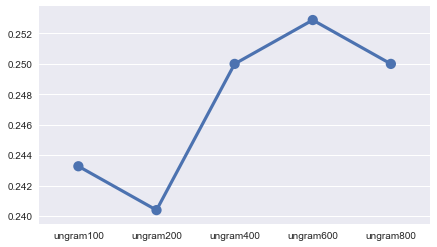

In [0]:
sns.set(style="darkgrid")

# Set up the matplotlib figure
plt.figure(figsize=(7, 4))
sns.pointplot(x=list(ugram_score.keys()),y=list(ugram_score.values()))

Bigram model

where N is 2:

$𝑃(𝑤_1,𝑤_2,𝑤_3,…,𝑤_𝑘 )=∏_{𝑖=1}^{𝑘}𝑃 (𝑤_𝑖|w_{i-1})$

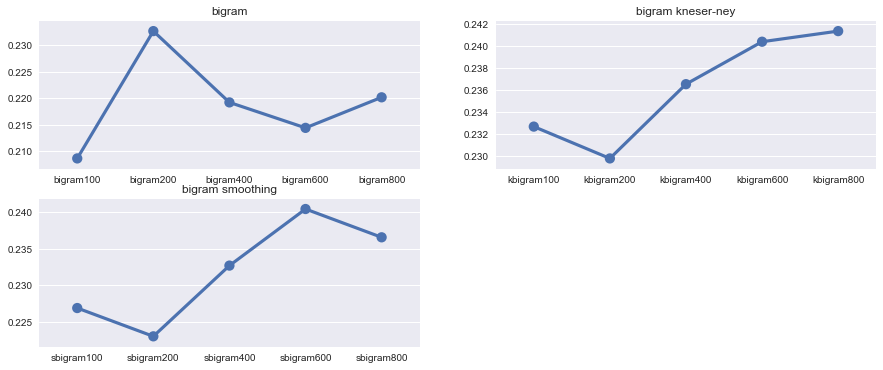

In [0]:
sns.set(style="darkgrid")
# Set up the matplotlib figure
# f, ax1 = plt.subplots(2, 2, figsize=(15, 6), sharex=True)
plt.figure(figsize=(15, 6))
plt.subplot(221)
plt.title('bigram')
sns.pointplot(x=list(bigram_score.keys()),y=list(bigram_score.values()))
plt.subplot(222)
plt.title('bigram kneser-ney')
sns.pointplot(x=list(kbigram_score.keys()),y=list(kbigram_score.values()))
plt.subplot(223)
plt.title('bigram smoothing')
sns.pointplot(x=list(sbigram_score.keys()),y=list(sbigram_score.values()))

Trigram model

where N is 3:

$𝑃(𝑤_1,𝑤_2,𝑤_3,…,𝑤_𝑘 )=∏_{𝑖=1}^{𝑘}𝑃 (𝑤_𝑖|w_{i-1}w_{i-1})$

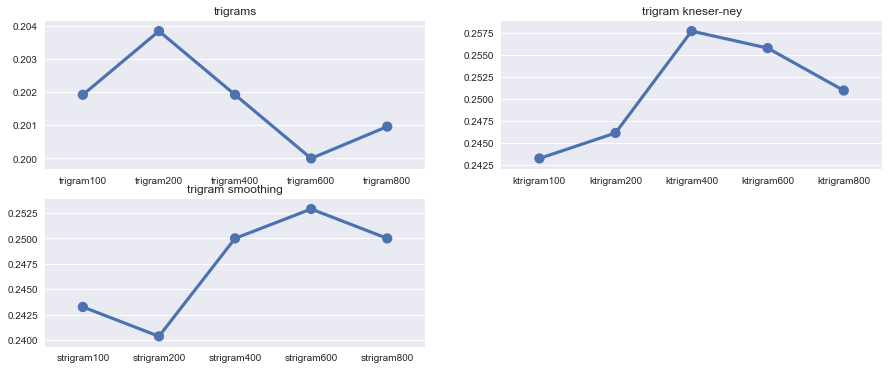

In [0]:
sns.set(style="darkgrid")
# Set up the matplotlib figure
plt.figure(figsize=(15, 6))
plt.subplot(221)
plt.title('trigrams')
sns.pointplot(x=list(trigram_score.keys()),y=list(trigram_score.values()))
plt.subplot(222)
plt.title('trigram kneser-ney')
sns.pointplot(x=list(ktrigram_score.keys()),y=list(ktrigram_score.values()))
plt.subplot(223)
plt.title('trigram smoothing')
sns.pointplot(x=list(strigram_score.keys()),y=list(strigram_score.values()))

Producets of probabilites:

when we use logs to compuate the probabilities, it not only can avoid underfolw but also computationally more efficient. Beacuse computing adding is easier than mutiplying $log(p_1xp_2x...p_n)=log(p_1)+log(p_2)+...+log(P_n)$

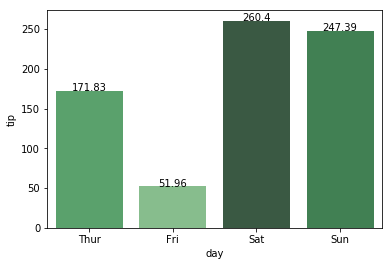

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = sns.load_dataset("tips")
groupedvalues=df.groupby('day').sum().reset_index()

pal = sns.color_palette("Greens_d", len(groupedvalues))
rank = groupedvalues["total_bill"].argsort().argsort() 
g=sns.barplot(x='day',y='tip',data=groupedvalues, palette=np.array(pal[::-1])[rank])

for index, row in groupedvalues.iterrows():
    g.text(row.name,row.tip, round(row.tip,2), color='black', ha="center")

plt.show()